Below are 2 plots for each classifier:
* The right plot is is the confusion matrix for the classifier.<br/>The x axis for the predicted users vs the true user in the y exis.<br/>True positive values are in the main diagonal(upper left to lower right).
* The left plot shows the <i>ROC</i> plot and the <i>AUC</i> score for each user.<br/>The auc is a derivative product of the data obtained in the confusion matrix.<br/>Eeach tick along the x axis represents a limit in the modal, the limit defines what is considered a <b>true</b> poitive prediction or a <b>false</b> one.<br/>For each limit(x value) a y score is calculated using the formula: FP / (TN + FP) giving an indication for the precision at thet threshold(limit).<br/>The AUC score is the area created by the AUC curve and gives an indication for the overall prediction accuracy for a given user by thet classifier.

The classifiers are:
* Support Vector Classification
* Linear Support Vector Classification
* Stochastic Gradient Descent Classifier
* Perceptron
* Logistic Regression
* Logistic Regression Cross Validation

All classifiers wore chosen becuse they are inherently multiclass classifiers.

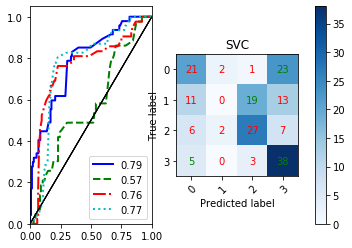

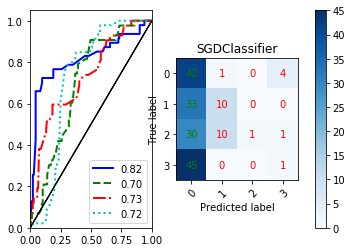

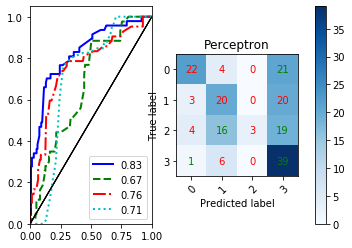

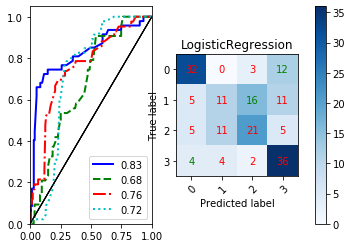

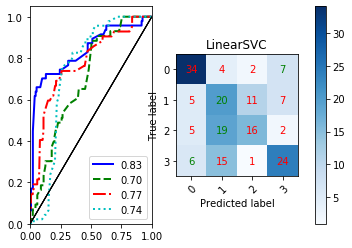

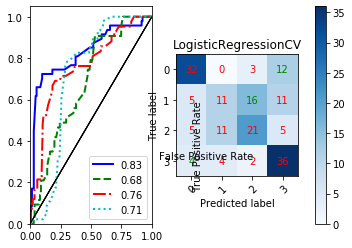

In [6]:
ua.plot_roc_auc()

In [5]:
import json, re, os, random, logging, time, traceback
from functools import reduce
import pandas as pd
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt
import requests
import selenium
from seleniumwire import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from browsermobproxy import Server
from collections import Counter
from sklearn import svm
from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, LogisticRegressionCV, \
    PassiveAggressiveClassifier
from sklearn import neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer


class Har:
    @staticmethod
    def from_csv(path: str) -> list:
        """Transform each har_fit file in the path to a Pandas DataFrame,
            add each DataFrame to a list,
            and return the list.

        :param str path: The path to the har_fit files directory.
        :return list: A list of the har_fit files data in Pandas DataFrames.
        """

        hars = []

        for file in os.listdir(path):
            if file[-4:] == '.csv':
                hars.append(pd.read_csv(f'{path}/{file}'))

        return hars


    @staticmethod
    def capture_n_har_files(path: str, page: str = None, n: int = 1, name: str = '', url: str = '', rnd: bool = False,
                            page_func=''):
        """Run n times:
            Create an Har class instance.
            Using BrowsermobProxy start recording har data from the browser.
            Using selenium start a browser and go to the url.
            Perform the action ordered by the 'page_func' function.
            Create a Pandas DataFrame from the har data recorded.
            Close the selenium session and the proxy.
            Export the DataFrame to a csv file.

        :param page_func: A custom function for action to perform inside the webpage.
        :param path: csv file/s save location.
        :param rnd: Whether to choose a random url.
        :param n: Number of times to run.
        :param name: Record name.
        :param url: The web site, use full address(exm: http://www.google.com).
        """

        urls = ['https://www.tumblr.com/', 'https://findtheinvisiblecow.com/', 'https://theuselessweb.com/',
                'https://www.linkedin.com/', 'https://www.reddit.com/', 'https://www.taringa.net/',
                'https://the-dots.com/', 'https://www.youtube.com/',
                'https://www.reverbnation.com/', 'https://www.flixster.com/', 'https://www.care2.com/',
                'https://www.ravelry.com/account/login'
                'http://hackertyper.com/', 'https://www.instagram.com/', 'https://twitter.com/',
                'https://www.pinterest.com/']

        try:
            _ = re.findall('\\d+', os.listdir(f'{path}').__str__())
            __ = list(map(lambda x: int(x), _))
            last_i = max(__) + 1
        except ValueError:
            last_i = 0

        for i in range(last_i, last_i + n):
            if rnd:
                url = urls[random.randrange(len(urls))]

            print(str(i) + ' ' + url)

            har = Har()
            har._capture_data(name, url, page_func=page_func, page=page)
            har._build_df()
            har.quit()

            har.export_df(f'{path}/har_df_{i}.csv')


    def _capture_data(self, name, url, page_func, page):
        """
        :param name: The har output name.
        :param url: The website to capture har data from.
        :param page_func: A custom function ordering the actions to perform inside the web page.
        """

        self.proxy.new_har(name)
        self.driver.get(url)

        if page_func != '':
            page_func(self.driver, page)


    def __init__(self, path=None):
        if path is None:
            self.server = Server(
                'C:/Users/Geco/AngularProjects/BuildUrlDatabase/py/browsermob-proxy-2.1.4/bin/browsermob-proxy.bat')
            self.server.start()
            self.proxy = self._start_proxy()
            self.driver = self._start_chrome_driver()
            self.df = None
        else:
            self.df = pd.read_csv(f'{path}')


    def _start_proxy(self):
        """Start a new proxy server to capture har data.

        :return: The new server proxy.
        """

        run = True

        while run:
            try:
                proxy = self.server.create_proxy()
                run = False
            except requests.exceptions.ConnectionError as e:
                print(e)

        return proxy


    def _start_chrome_driver(self) -> webdriver:
        """Using Selenium start the google chrome browser headless.
        All the browser requests and responses(har_fit data) will be recorded
        using a BrowsermobProxy proxy server.

        :return: Google chrome driver object.
        """

        chrome_options = webdriver.ChromeOptions()
        prefs = {"profile.default_content_setting_values.notifications": 2}
        chrome_options.add_experimental_option("prefs", prefs)
        chrome_options.set_capability('proxy', {'httpProxy': f'{self.proxy.proxy}',
                                                'noProxy': '',
                                                'proxyType': 'manual',
                                                'sslProxy': f'{self.proxy.proxy}'})
        # chrome_options.add_argument("--headless")

        driver = webdriver.Chrome(chrome_options=chrome_options)
        driver.set_page_load_timeout(999)
        driver.delete_all_cookies()

        return driver


    def quit(self):
        """Close all open connections: Close the proxy server and the chrome driver.
        """
        self.driver.quit()
        self.server.stop()
        os.system("taskkill /f /im java.exe")


    def export_har(self):
        """
        Export the har_fit recording to a json file.
        """
        with open('./har_fit.json', 'w') as file:
            json.dump(self.proxy.har, file)


    def export_df(self, path):
        """
        Export the instance DataFrame to a csv file.
        :param path: Export directory path.
        """
        self.df.to_csv(path)


    def _add_to_dict(self, __, k, v):
        """Utility method for the build_df method.
        """
        if type(v) == list:
            for kk, vv in v:
                if type(vv) == dict or type(vv) == list:
                    self._add_to_dict(__, k + kk + '.', vv)
                else:
                    __[k + kk] = vv
        else:
            for kk, vv in v.items():
                if type(vv) == dict or type(vv) == list:
                    self._add_to_dict(__, k + kk + '.', vv)
                else:
                    __[k + kk] = vv


    def _build_df(self):
        """
        Iterate each row in the har_fit data csv file
        and add it to a dictionary.
        Add all the rows dictionaries to a list.
        Create one complete DataFrame from the list.

        :return: The instance har_fit recording data in the form of a Pandas DataFrame.
        """
        _ = list()

        for entry in self.proxy.har['log']['entries']:
            __ = dict()

            for k, v in entry.items():
                if type(v) == dict or type(v) == list:
                    self._add_to_dict(__, k + '.', v)
                else:
                    __[k] = v

            _.append(__)

        self.df = pd.DataFrame(_)


class FingerPrint:
    def __init__(self, hars, types: bool = False):
        self.hars = hars
        self.length = len(hars)
        self.sums = []
        self.sessions = []
        self.weights = None

        self._init_data()
        self._init_weights()

        if types:
            self.types_counts = self._gather_types()
            self.types = self._get_types()


    def _gather_types(self):
        _ = []

        for df in self.hars:
            __ = {}

            for row in df.iterrows():
                try:
                    ___ = re.findall('(?<=\.)\w{1,4}$', row[1]['request.url'])[0]

                    if ___ in __:
                        __[___] += 1
                    else:
                        __[___] = 1
                except IndexError:
                    pass

            _.append(__)

        return _


    def _get_types(self):
        _ = []

        for session in self.types_counts:
            for k in session.keys():
                if k not in _:
                    _.append(k)

        return _


    def _init_data(self):
        for har in self.hars:
            session_sums = [0, 0]
            session = []

            for row in har[['response.bodySize', 'response.headersSize', 'time']].values:
                row = tuple(row.tolist())

                # Add to sums.
                session_sums[0] += row[0]
                session_sums[1] += row[1]

                session.append(row)

            # Add to count.
            self.sessions.append(session)
            self.sums.append(session_sums)


    def _flatten_sessions(self):
        return [row for session in self.sessions for row in session]


    def _init_weights(self):
        flat_sessions = self._flatten_sessions()
        self.weights = Counter(flat_sessions)


class ResponseData:
    def __init__(self, hars: list, types: bool = False):
        self.hars = hars
        self.length = len(hars)
        self.sums = []
        self.sessions = []

        self._init_data()

        if types:
            self.types_counts = self._gather_types()


    def _init_data(self):
        """Sum body size and header size individually for each session: (body size, header size)
           Create a tuple of (body size, header size) per session then add each session to self.sessions."""
        for har in self.hars:
            session_sums = [0, 0]
            session = []

            for row in har[['response.bodySize', 'response.headersSize', 'time']].values:
                row = tuple(row.tolist())

                session_sums[0] += row[0]
                session_sums[1] += row[1]

                session.append(row)

            self.sums.append(session_sums)
            self.sessions.append(session)


    def _gather_types(self):
        _ = []

        for df in self.hars:
            __ = {}

            for row in df.iterrows():
                try:
                    ___ = re.findall('(?<=\.)\w{1,4}$', row[1]['request.url'])[0]

                    if ___ in __:
                        __[___] += 1
                    else:
                        __[___] = 1
                except IndexError:
                    pass

            _.append(__)

        return _


class Analyzer:
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        self.fp = fp  # Fit data.
        self.rd = rd  # Predict data.
        self.x_fit = []
        self.x_predict = []
        self.y_fit_true = []
        self.y_predict_true = []
        self.clf = []


    def plot_confusion_matrix(self, title=None, cmap=plt.cm.Blues):
        """This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """

        # Compute confusion matrix
        cm = confusion_matrix(self.y_predict_true, self.predictions[0])
        # Only use the labels that appear in the data
        classes = unique_labels(self.y_fit_true, self.y_predict_true)

        print(classification_report(self.y_predict_true, self.predictions[0], labels=[0, 1],
                                    target_names=['facebook', 'other']))

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', extent=[-.5, cm.shape[1] - .5, -.5, cm.shape[1] - .5], cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.flip(np.arange(cm.shape[0])),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="center")
        plt.setp(ax.get_yticklabels(), va="center")

        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[cm.shape[1] - i - 1, j], 'd'), ha="center", va="center",
                        color="red" if cm[i, j] > thresh else "green")

        fig.tight_layout()


    def plot_roc_auc(self, title=''):
        clf_names = {0: 'SVC', 1: 'SGDClassifier', 2: 'Perceptron',
                     3: 'LogisticRegression', 3: 'LinearSVC', 4: 'LogisticRegressionCV'}

        for i, c in enumerate(self.clf):
            y_score = c.decision_function(self.x_predict)

            fpr, tpr, _ = roc_curve(self.y_predict_true, y_score)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, lw=2, label=f'{clf_names[i]}  {roc_auc:.2f}')
            plt.plot([0, 1], [0, 1], lw=1, color='k', linestyle='-')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc="lower right")


class TypesAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData, test_size: float):
        super().__init__(fp, rd)

        self.dict_vectorizer = DictVectorizer(sparse=False)
        self._init_data()
        self.clf = self._classify(test_size)
        self.predictions = [c.predict(self.x_predict) for c in self.clf]


    def _init_data(self):
        _ = []

        for session_types in self.rd.types_counts:
            __ = {}

            for t in self.fp.types:
                if t in session_types:
                    __[t] = session_types[t]
                else:
                    __[t] = 0

            _.append(__)

        self.x_fit = self.dict_vectorizer.fit_transform(self.fp.types_counts)
        self.y_fit_true = [1] * self.x_fit.shape[0]
        self.x_predict = self.dict_vectorizer.transform(_)
        self.y_predict_true = [0] * self.x_predict.shape[0]


    def _classify(self, test_size):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit.data, self.x_predict.data]),
            np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=test_size)

        clf = [svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true),
               SGDClassifier().fit(self.x_fit, self.y_fit_true),
               Perceptron().fit(self.x_fit, self.y_fit_true),
               LogisticRegression(solver='lbfgs').fit(self.x_fit, self.y_fit_true),
               svm.LinearSVC(max_iter=5000).fit(self.x_fit, self.y_fit_true),
               LogisticRegressionCV(cv=5).fit(self.x_fit, self.y_fit_true)]

        return clf


class WeightsAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData, test_size: float):
        super().__init__(fp, rd)

        self._init_data()
        self.clf = self._classify(test_size)
        self.predictions = [c.predict(self.x_predict) for c in self.clf]


    def _score_sessions(self, sessions: list, label: int):
        _ = []
        __ = []

        for session in sessions:
            session_score = 0

            for feature in self.fp.weights.keys():
                if feature in session:
                    session_score += 1

            _.append([session_score])
            __.append(label)

        return np.array(_), np.array(__)


    def _init_data(self):
        self.x_fit, self.y_fit_true = self._score_sessions(self.fp.sessions, 1)
        self.x_predict, self.y_predict_true = self._score_sessions(self.rd.sessions, 0)


    def _classify(self, test_size):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit, self.x_predict]), np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=test_size)

        clf = [svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true),
               SGDClassifier().fit(self.x_fit, self.y_fit_true),
               Perceptron().fit(self.x_fit, self.y_fit_true),
               LogisticRegression(solver='lbfgs').fit(self.x_fit, self.y_fit_true),
               svm.LinearSVC().fit(self.x_fit, self.y_fit_true),
               LogisticRegressionCV().fit(self.x_fit, self.y_fit_true)]

        return clf


class SumsAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData, test_size: float):
        super().__init__(fp, rd)

        self._init_data(test_size)
        self.clf = self._classify()
        self.predictions = self.clf.predict(self.x_predict)

        self.score = cross_val_score(self.clf, self.x_fit, y=self.y_fit_true, cv=5, scoring='f1_weighted')


    def _init_data(self, test_size):
        length = min(len(self.fp.hars), len(self.rd.hars))

        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.fp.sums[:length], self.rd.sums[:length]]), [1] * length + [0] * length,
            test_size=test_size)


    def _classify(self):
        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)


    def plot_scatter(self):
        x_fp = np.array(self.fp.sums)[:, 0]
        y_fp = np.array(self.fp.sums)[:, 1]

        x_rd = np.array(self.rd.sums)[:, 0]
        y_rd = np.array(self.rd.sums)[:, 1]

        plt.scatter(x_rd, y_rd, label='other')
        plt.scatter(x_fp, y_fp, label='facebook')
        plt.legend()
        plt.ylabel('Size')
        plt.xlabel('Time')


class CombinedAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData, test_size: float):
        super().__init__(fp, rd)

        self.dict_vectorizer = DictVectorizer(sparse=False)
        self._init_data()
        self.clf = self._classify(test_size)
        self.predictions = self.clf.predict(self.x_predict)

        self.score = cross_val_score(self.clf, self.x_fit, y=self.y_fit_true, cv=5, scoring='f1_weighted')


    def _init_data(self):
        length = min(self.fp.length, self.rd.length)

        # Add the type feature.
        self.x_fit = self.dict_vectorizer.fit_transform(self.fp.types_counts[:length]).tolist()
        self.x_predict = self.dict_vectorizer.transform(self.rd.types_counts[:length]).tolist()

        for session_i in range(length):
            # Add the sums feature.
            self._add_sums(session_i)

            # Add the weight score. 0 by default.
            self.x_fit[session_i].append(0)
            self.x_predict[session_i].append(0)

            # Add the weights feature.
            self._add_weights(session_i)

            # Add labels
            self.y_fit_true.append(1)
            self.y_predict_true.append(0)


    def _add_sums(self, i):
        self.x_fit[i].append(self.fp.sums[i][0])
        self.x_fit[i].append(self.fp.sums[i][1])
        self.x_predict[i].append(self.rd.sums[i][0])
        self.x_predict[i].append(self.rd.sums[i][1])


    def _add_weights(self, i):
        for feature in self.fp.weights.keys():
            if feature in self.fp.sessions[i]:
                self.x_fit[i][-1] += 1
            if feature in self.rd.sessions[i]:
                self.x_predict[i][-1] += 1


    def _classify(self, test_size):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit, self.x_predict]), np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=test_size)

        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)


class UsersAnalyzer:
    def __init__(self, data: list, flags: str = 't', test_size: float = 0.25):
        self.flags = flags
        self.data = data
        self.dict_vectorizer = DictVectorizer(sparse=False)
        self.x_fit = []
        self.y_fit_true = []
        self._split_i = {}

        self._init()
        self.clf = self._classify(test_size)
        self.predictions = [c.predict(self.x_predict) for c in self.clf]


    def _init(self):
        if 't' in self.flags:
            _ = reduce(lambda a, b: a + b, [x.types_counts for x in self.data])

            if type(self.x_fit) == np.ndarray:
                _ = np.array(_).reshape(self.x_fit.shape[0], len(_[0]))
                self.x_fit = np.concatenate([self.x_fit, _], axis=1)
                self.y_fit_true.extend([[i] * len(self.data[i].types_counts) for i in range(len(self.data))])
            else:
                self.x_fit = self.dict_vectorizer.fit_transform(_)
                self.y_fit_true = [[i] * len(self.data[i].types_counts) for i in range(len(self.data))]

        if 's' in self.flags:
            _ = reduce(lambda a, b: a + b, [x.sums for x in self.data])

            if type(self.x_fit) == np.ndarray:
                _ = np.array(_).reshape(self.x_fit.shape[0], 2)
                self.x_fit = np.concatenate([self.x_fit, _], axis=1)
                self.y_fit_true.extend([[i] * len(self.data[i].sums) for i in range(len(self.data))])
            else:
                self.x_fit = np.array(_)
                self.y_fit_true = [[i] * len(self.data[i].sums) for i in range(len(self.data))]
        if 'w' in self.flags:
            _ = reduce(lambda a, b: a + b, [x.sessions for x in self.data])

            if type(self.x_fit) == np.ndarray:
                self.x_fit = np.concatenate([self.x_fit, _])
                self.y_fit_true.extend([[i] * len(self.data[i].sessions) for i in range(len(self.data))])
            else:
                self.x_fit = _
                self.y_fit_true = [[i] * len(self.data[i].sessions) for i in range(len(self.data))]

        self.y_fit_true = np.array(
            reduce(lambda a, b: a + b, [[i] * len(self.data[i].sessions) for i in range(len(self.data))]))


    def _classify(self, test_size):
        sss = StratifiedShuffleSplit(n_splits=len(self.data), test_size=test_size)
        _, __ = [], []

        for i, (fit_i, train_i) in enumerate(sss.split(self.x_fit, self.y_fit_true)):
            self._split_i[i] = (fit_i, train_i)

            _.extend(self.x_fit[fit_i])
            __.extend(self.y_fit_true[fit_i])

            self.x_predict = self.x_fit[train_i]
            self.y_predict_true = self.y_fit_true[train_i]

        self.x_fit = _
        self.y_fit_true = __

        clf = [svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true),
               SGDClassifier().fit(self.x_fit, self.y_fit_true),
               Perceptron().fit(self.x_fit, self.y_fit_true),
               LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=100000).fit(self.x_fit, self.y_fit_true),
               svm.LinearSVC().fit(self.x_fit, self.y_fit_true),
               LogisticRegressionCV(cv=5, multi_class='auto', max_iter=100000).fit(self.x_fit, self.y_fit_true),
               PassiveAggressiveClassifier().fit(self.x_fit, self.y_fit_true)]

        return clf


    def print_scores(self):
        print(classification_report(self.y_predict_true, self.predictions, labels=range(len(self.data)),
                                    target_names=[str(i) for i in range(len(self.data))]))


    def plot_roc_auc(self):
        colors = ['b', 'g', 'r', 'c']
        linestyles = ['-', '--', '-.', ':']
        classes = unique_labels(self.y_fit_true, self.y_predict_true)
        clf_names = {0: 'SVC', 1: 'SGDClassifier', 2: 'Perceptron',
                     3: 'LogisticRegression', 4: 'LinearSVC', 5: 'LogisticRegressionCV',
                     6: 'PassiveAggressiveClassifier'}

        # fig, ax = plt.subplots(2, 3, sharey=True, squeeze=True)

        for i in range(len(self.clf) - 1):
            fig, ax = plt.subplots(1, 2)

            y_score = self.clf[i].decision_function(self.x_predict)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            plt.title(clf_names[i])
            # ax.ravel()[i].set_title(clf_names[i])

            for j in range(len(self.data)):
                fpr[j], tpr[j], _ = roc_curve(self.y_predict_true, y_score[:, j], pos_label=j)
                roc_auc[j] = auc(fpr[j], tpr[j])

                ax[0].plot(fpr[j], tpr[j], color=colors[j], linestyle=linestyles[j], lw=2,
                           label=f'{roc_auc[j]:.2f}')
                ax[0].plot([0, 1], [0, 1], lw=1, color='k', linestyle='-')
                ax[0].set_xlim([0.0, 1.0])
                ax[0].set_ylim([0.0, 1.05])
                ax[0].legend()

            cm = confusion_matrix(self.y_predict_true, self.predictions[i])
            im = ax[1].imshow(cm, interpolation='nearest', extent=[-.5, cm.shape[1] - .5, -.5, cm.shape[0] - .5],
                              cmap=plt.cm.Blues)
            ax[1].figure.colorbar(im, ax=ax)
            ax[1].set(xticks=np.arange(cm.shape[1]),
                      yticks=np.flip(np.arange(cm.shape[0])),
                      # ... and label them with the respective list entries
                      xticklabels=classes, yticklabels=classes,
                      title=clf_names[i],
                      ylabel='True label',
                      xlabel='Predicted label')

            plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

            thresh = cm.max() / 2.

            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax[1].text(j, i, format(cm[cm.shape[0] - i - 1, j], 'd'),
                               ha="center", va="center",
                               color="green" if cm[i, j] > thresh else "red")

        plt.text(.5, .04, 'False Positive Rate', ha='center')
        plt.text(.04, .5, 'True Positive Rate', va='center', rotation='vertical')
        # handles, labels = ax.ravel()[0].get_legend_handles_labels()
        # fig.legend(handles=handles, labels=[f'User{i}' for i in range(len(self.data))])


    def plot_confusion_matrix(self, title=None, cmap=plt.cm.Blues):
        """This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """

        # Compute confusion matrix
        cm = confusion_matrix(self.y_predict_true, self.predictions)
        # Only use the labels that appear in the data
        classes = unique_labels(self.y_fit_true, self.y_predict_true)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', extent=[-.5, cm.shape[1] - .5, -.5, cm.shape[0] - .5], cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.flip(np.arange(cm.shape[0])),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 # rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[cm.shape[0] - i - 1, j], 'd'),
                        ha="center", va="center",
                        color="g" if cm[i, j] > thresh else "r")

        fig.tight_layout()


def page_func(driver, page):
    """Passed to the Har.capture_n_har_files procedure for selenium to run
    on the web page.
    """
    timeout = 10

    email_xpath = '//input[@id="email"] | //input[@name="email"]'
    pass_xpath = '//input[@id="pass"] | //input[@name="pass"]'
    login_xpath = '//input[@value="Log In"] | //button[@name="login"]'
    page_xpath = '//span[text()="' + page + '"]'

    # Make sure all elements exist on page before moving on.
    run = True

    while run:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, email_xpath)))
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, login_xpath)))
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, pass_xpath)))

            run = False
        except selenium.common.exceptions.NoSuchElementException:
            print('Login NoSuchElementException.')
        except selenium.common.exceptions.TimeoutException:
            print('Login TimeoutException.')

    driver.find_element_by_xpath(email_xpath).send_keys('gggppp282@gmail.com')
    driver.find_element_by_xpath(pass_xpath).send_keys('g31012310G')
    driver.find_element_by_xpath(login_xpath).click()

    # Make sure all elements exist on page before moving on.
    run = True

    while run:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//div[text()="Pages"]')))

            run = False
        except selenium.common.exceptions.NoSuchElementException:
            print('Login NoSuchElementException.')
        except selenium.common.exceptions.TimeoutException:
            print('Login TimeoutException.')

    driver.find_element_by_xpath('//div[text()="Pages"]').click()

    # Make sure all elements exist on page before moving on.
    run = True

    while run:
        try:
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, page_xpath)))

            run = False
        except selenium.common.exceptions.NoSuchElementException:
            print('Login NoSuchElementException.')
        except selenium.common.exceptions.TimeoutException:
            print('Login TimeoutException.')

    driver.find_element_by_xpath(page_xpath).click()


def capture_har_data(n, page_func=None, page=None):
    """Utility procedure to create n HAR files, both for the fingerprint
        and random.
    """
    for i in range(n):
        print('\nCapturing FingerPrint HAR data...')
        Har.capture_n_har_files(path='./har_fit', n=1, url='https://www.facebook.com', name='facebook',
                                page_func=page_func, page=page)

        # print('\nCapturing ResponseData HAR data...')
        # Har.capture_n_har_files(path='./har_random', n=1, rnd=True)


def run_analyzers(fp, rd):
    wa = WeightsAnalyzer(fp, rd)
    sa = SumsAnalyzer(fp, rd)
    ta = TypesAnalyzer(fp, rd)
    ca = CombinedAnalyzer(fp, rd)

    wa.plot_roc_auc(title='WeightsAnalyzer')
    sa.plot_roc_auc(title='SumsAnalyzer')
    ta.plot_roc_auc(title='TypesAnalyzer')
    ca.plot_roc_auc(title='CombinedAnalyzer')


users = ['./har_fit_0', './har_fit_1', './har_fit_2', './har_fit_3']

fp = [FingerPrint(Har.from_csv(user), types=True) for user in users]
ua = UsersAnalyzer(fp, flags='t', test_size=0.4)

/home/geco/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
